<b>Authors:</b> Jaya Sai Amirineni(783115) & Akshat Gupta(893717)<br>
<b>Python version:</b> 3<br>
<b>Requirements :</b> keras, tensorflow-gpu, scikit-learn and vectormap of pre-trained glove vectors of 6 billion words (dimensions=100) <br>
<b>Training time :</b> 3 hours approx(on nvidia GTX 1050 gpu)

We have used Bidirectional Attention Flow(BiDAF) mechanism to implement the Question Answering system for the given datasets using keras with tensorflow backend. We input the paragraph word vectors and question word vectors into two different Bidirectional Gated recurrent units(GRU) which encode the sequence data into fixed size vectors. Now we use the encoded paragraph and question vectors to calculate the attention from question to paragraph and paragraph to question using the attention layer. The output from the attention layer is then passed through another bidirectional GRU and finally give the start and end spans using a Dense layer connected to both modelling layer and attention layer. We also used Tfidf to get the relevent paragraph for the given question from a list of paragraphs

Importing all necessary packages for processing

In [94]:
import json,random,re,pickle,csv
import numpy as np
from keras import backend as K
from keras.utils import Sequence
from keras.models import Model,load_model
from keras.layers import Input, InputLayer,Dropout,CuDNNLSTM,CuDNNGRU
from keras.layers.merge import Concatenate
from keras.engine.topology import Layer
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import wordnet,stopwords
from nltk.stem.lancaster import LancasterStemmer as ls
from matplotlib import pyplot as plt
from keras.callbacks import History,ModelCheckpoint
from nltk.tokenize import word_tokenize
from nltk.tokenize.moses import MosesDetokenizer
from keras.utils import plot_model
from pylab import figure,axes

Load the training, development, and testing datasets into memory (skip this step if loading from pickled dataset objects)

In [103]:
documents = {}
with open('documents.json') as f:
    docs = json.load(f)
for doc in docs:
    documents[doc['docid']] = doc['text']
with open('training.json') as f:
    training_set = json.load(f)
with open('devel.json') as f:
    development_set = json.load(f)
with open('testing.json') as f:
    testing_set = json.load(f)
vector_map = {}
with open('glove.6B.100d.txt',encoding='UTF-8') as f:
    for line in f:
        word,vector = tuple(line.split(" ",1))
        vector_map[word] = np.fromstring(vector,sep=" ")

Necessary functions for preprocessing

In [13]:
stop_words = stopwords.words('english')
word_vectors = list(vector_map.values())
vector_stack = np.vstack(word_vectors)
variance = np.var(vector_stack,0)
mean = np.mean(vector_stack,0)
random_state = np.random.RandomState()
def get_unk_vec(unk):
    vector_map[unk] = random_state.multivariate_normal(mean,np.diag(variance))
    return vector_map[unk]
def get_paragraph_vector(paragraph):
    puncts = ['"',',','.','-',"'",'(',')','?',';',':','$','%','#','—','!','–','&','/','[',']','~','+','<','>']
    digits = ['zero','one','two','three','four','five','six','seven','eight','nine']
    i_digits = ['first','second','third','fourth','fifth','sixth','seventh','eighth','nineth']
    paragraph = paragraph.replace('’',"'")
    #paragraph = paragraph.replace('',"'")
    paragraph = paragraph.replace('``','"')
    paragraph = paragraph.replace("''",'"')
    paragraph = paragraph.replace('“','"')
    paragraph = paragraph.replace('”','"')
    for punct in puncts:
        paragraph = paragraph.replace(punct,' '+punct+' ')
    paragraph.replace(" "," ")
    paragraph = paragraph.replace('  ',' ')
    tokens = paragraph.strip().lower().split(' ')
    #tokens = word_tokenize(paragraph)
    vecs = []
    words = []
    #print(paragraph)
    for token in tokens:
        token = re.sub(r"(?<=\d)(st|nd|rd|th)\b", '', token)
        if token in digits:
            token = str(digits.index(token))
        if token in i_digits:
            token = str(i_digits.index(token)+1)
        if token in vector_map:
            vecs.append(vector_map[token])
            words.append(token)
        else:
            vecs.append(get_unk_vec(token))
            words.append(token)
    return words,vecs
def get_span(context,answer):
    spans = []
    l = len(answer)
    cl = len(context)
    stop_idx = cl-l
    st = ls()
    for index,token in enumerate(context):
        if index > stop_idx:
            break
        if token == answer[0]:
            i = index
            found = True
            for a_token in answer:
                if a_token!=context[i] and st.stem(a_token)!=st.stem(context[i]):
                    found = False
                    break
                i+=1
            if found:
                spans.append((index,index+l))   
    if len(spans) == 0:
        if l == 1:
            for index,token in enumerate(context):
                if st.stem(token) == st.stem(answer[0]):
                    return (index,index) 
        #print(context,answer)
        return (None,None)
    elif len(spans) == 1:
        return spans[0]
    else:
        r = random.randint(0,len(spans)-1)
        return spans[r]
def vectorize(documents,qas,test=False):
    contexts = []
    c_tokens = []
    questions = []
    starts = []
    ends = []
    for qa in qas:
        if test:
            context_tokens,context_vectors = get_paragraph_vector(documents[qa['docid']][get_relevent_paragraph(documents[qa['docid']],qa['question'])])
        else:
            context_tokens,context_vectors = get_paragraph_vector(documents[qa['docid']][qa['answer_paragraph']])
        _,question_vectors = get_paragraph_vector(qa['question'])
        if not test:
            answer_tokens, _ = get_paragraph_vector(qa['text'])
            start,end = get_span(context_tokens,answer_tokens)
            starts.append(start)
            ends.append(end)
        contexts.append(context_vectors)
        c_tokens.append(context_tokens)
        questions.append(question_vectors)
    data = (contexts,questions,starts,ends,c_tokens)
    return data
def get_relevent_paragraph(document,question):
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    tfidf = vectorizer.fit_transform(document+[question])
    cosine_similarities = linear_kernel(tfidf[-1:], tfidf[:-1]).flatten()
    related_docs_indices = cosine_similarities.argsort()[:-4:-1]
    return related_docs_indices[0]
def pad_sequences(sequences, maxlen=None,dim=100, value=0.0,dtype='float32',padding='post', truncating='post'):
    lengths = [len(s) for s in sequences]

    nb_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    x = (np.ones((nb_samples, maxlen, dim)) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError("Truncating type '%s' not understood" % padding)

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError("Padding type '%s' not understood" % padding)
    return x
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb+') as f:
        return pickle.load(f)

Preprocessing the data(skip this step if loading from pickled objects)

In [4]:
p_max = 400
q_max = 100
train_dataset = {}
dev_dataset = {}
test_dataset = {}
train_dataset['train_ctx'],train_dataset['train_q'],train_dataset['train_start'],train_dataset['train_end'],train_dataset['train_tokens'] = vectorize(documents,training_set)
dev_dataset['dev_ctx'],dev_dataset['dev_q'],dev_dataset['dev_start'],dev_dataset['dev_end'],dev_dataset['dev_tokens'] = vectorize(documents,development_set)
test_dataset['test_ctx'],test_dataset['test_q'],_,_,test_dataset['test_tokens'] = vectorize(documents,testing_set,True)
def get_span_array(arr,max_len):
    l = len(arr)
    x = np.zeros((l,max_len))
    for idx,ele in enumerate(arr):
        if ele is not None and ele<max_len:
            x[idx][int(ele)] = 1
    return x
train_dataset['train_start'] = get_span_array(train_dataset['train_start'],p_max)
dev_dataset['dev_start'] = get_span_array(dev_dataset['dev_start'],p_max)
train_dataset['train_end'] = get_span_array(train_dataset['train_end'],p_max)
dev_dataset['dev_end'] = get_span_array(dev_dataset['dev_end'],p_max)
save_obj(train_dataset,'train')
save_obj(dev_dataset,'dev')
save_obj(test_dataset,'test')
save_obj(vector_map,'vectors')

Load pickled preprocessed data from storage (do not run if starting from scratch without pickle files)

In [2]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb+') as f:
        return pickle.load(f)
test_dataset = load_obj('test')
train_dataset = load_obj('train')
dev_dataset = load_obj('dev')
vector_map = load_obj('vectors')

batch generator for training the neural network by dynamically loading the data into memory to avoid out of memory errors 

In [3]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, ctx, q, start, end,p_max=500,q_max=100 ,batch_size=100):
        'Initialization'
        self.batch_size = batch_size
        self.ctx = ctx
        self.q = q
        self.start = start
        self.end = end

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.ctx) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if ((index+1)*self.batch_size)<len(self.ctx):
            indexes = [index*self.batch_size,(index+1)*self.batch_size]
        else:
            indexes = [index*self.batch_size,len(self.ctx)]

        # Find list of IDs
        ctx_temp = self.pad_sequences(self.ctx[indexes[0]:indexes[1]],maxlen = p_max)
        q_temp = self.pad_sequences(self.q[indexes[0]:indexes[1]],maxlen = q_max)
        # Generate data
        X, Y = [ctx_temp,q_temp],[self.start[indexes[0]:indexes[1]],self.end[indexes[0]:indexes[1]]]
        return X, Y
    def pad_sequences(self, sequences, maxlen=None,dim=100, value=0.0,dtype='float32',padding='post', truncating='post'):
        lengths = [len(s) for s in sequences]

        nb_samples = len(sequences)
        if maxlen is None:
            maxlen = np.max(lengths)

        x = (np.ones((nb_samples, maxlen, dim)) * value).astype(dtype)
        for idx, s in enumerate(sequences):
            if truncating == 'pre':
                trunc = s[-maxlen:]
            elif truncating == 'post':
                trunc = s[:maxlen]
            else:
                raise ValueError("Truncating type '%s' not understood" % padding)

            if padding == 'post':
                x[idx, :len(trunc)] = trunc
            elif padding == 'pre':
                x[idx, -len(trunc):] = trunc
            else:
                raise ValueError("Padding type '%s' not understood" % padding)
        return x
    

Custom layers implemented for handling Attention flow and giving output predictions

In [4]:
class BiDAF(Layer):

    def __init__(self, hdim, max_len, **kwargs):
        self.max_len = max_len
        self.hdim = hdim
        super(BiDAF, self).__init__(**kwargs)

    def build(self, input_shape):
        self.batch_size = input_shape[0][0]
        self.w = self.add_weight(name='w', 
                                      shape=(2 * self.hdim, 2 * self.hdim),
                                      initializer='uniform',
                                      trainable=True)
        super(BiDAF, self).build(input_shape)  # Be sure to call this at the end
        
    def similarity(self, p, q):
        #print(self.batch_size)
        w_tiled = K.tile(K.expand_dims(self.w, 0), [(K.shape(p))[0], 1, 1])
        q_T = tf.transpose(q, [0, 2, 1]) 
        
        S = tf.einsum('aij,ajk->aik', q_T, w_tiled)
        S = tf.einsum('aij,ajk->aik', S, p)
        return S
    def call(self, x):
        p = tf.transpose(x[0], [0, 2, 1])
        q = tf.transpose(x[1], [0 ,2 ,1])
        Similarity = self.similarity(p, q)
        H = self.Q2C(p, q, Similarity)
        U = self.C2Q(p, q, Similarity)
        G = K.concatenate([p, H, p * U, p * H], 1)
        G = tf.transpose(G, perm=[0, 2, 1])
        return G
    def C2Q(self, p, q, S):
        a = K.softmax(S, axis=1) 
        U = tf.matmul(q,a)
        return U
    def Q2C(self, p, q, S):
        b = K.softmax(tf.reduce_max(S, axis=1, keepdims=True))
        h = tf.einsum('aij,akj->aik', p, b)
        H = K.tile(h, [1, 1, self.max_len])
        return H
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0],self.max_len, 8*self.hdim)
class OutputLayer(Layer):

    def __init__(self, hdim, max_len, **kwargs):
        self.hdim = hdim
        self.max_len = max_len
        super(OutputLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.batch_size = input_shape[0][0]
        self.w_1 = self.add_weight(name='w_start', 
                                      shape=(10 * self.hdim, 1),
                                      initializer='uniform',
                                      trainable=True)
        self.w_2 = self.add_weight(name='w_end', 
                                      shape=(10 * self.hdim, 1),
                                      initializer='uniform',
                                      trainable=True)
        super(OutputLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        o1 = tf.concat([x[0], x[1]], 2) 
        o2 = tf.concat([x[0], x[1]], 2)
        #o1 = K.nn.dropout(temp1, dropout)
        #temp_2_o = tf.nn.dropout(temp2, dropout)
        w_1_tiled = K.tile(K.expand_dims(self.w_1, 0), [(K.shape(x[0]))[0], 1, 1])
        w_2_tiled = K.tile(K.expand_dims(self.w_2, 0), [(K.shape(x[0]))[0], 1, 1])
        pred_s = tf.squeeze(tf.einsum('aij,ajk->aik',o1, w_1_tiled),axis=2) # (?, m, 10h) * (?, 10h, 1) -> (?, m, 1)
        pred_e = tf.squeeze(tf.einsum('aij,ajk->aik',o2, w_2_tiled),axis=2) # (?, m, 10h) * (?, 10h, 1) -> (?, m, 1)
        return [K.softmax(pred_s), K.softmax(pred_e)]   
    def compute_output_shape(self, input_shape):
        return [(input_shape[0][0], self.max_len),(input_shape[0][0], self.max_len)]

Bidirectional attention flow model that we have implemented containing input layer,encoding layer, attention layer, modelling layer and output layer

In [16]:
batch_size = 80
dropout = 0.2
GD = 100
hdim = 128
p_max = 400
q_max = 100
def BiGRU(layer):
    forw = CuDNNGRU(hdim,return_sequences=True)(layer)
    back = CuDNNGRU(hdim,return_sequences=True,go_backwards=True)(layer)
    return Concatenate(2)([forw,back])
paragraph = Input(shape=(p_max,GD),dtype='float32')
question = Input(shape=(q_max,GD),dtype='float32')
paragraph_encoder = BiGRU(paragraph)
question_encoder = BiGRU(question)
attention_layer = BiDAF(hdim=hdim,max_len=p_max)([paragraph_encoder,question_encoder])
#dropout_layer = Dropout(dropout)(attention_layer)
modeling_layer = BiGRU(attention_layer)
#modeling_drop_out =  Dropout(dropout)(modeling_layer)
spans = OutputLayer(hdim,p_max)([attention_layer,modeling_layer])
model = Model(inputs=[paragraph,question],outputs=spans)
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['accuracy'])
model.summary()
history = History()
checkpointer = ModelCheckpoint("model/weights.{epoch:02d}.h5",monitor='val_acc',save_weights_only=True,period=1)
plot_model(model, to_file='model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 400, 100)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100, 100)     0                                            
__________________________________________________________________________________________________
cu_dnngru_7 (CuDNNGRU)          (None, 400, 128)     88320       input_3[0][0]                    
__________________________________________________________________________________________________
cu_dnngru_8 (CuDNNGRU)          (None, 400, 128)     88320       input_3[0][0]                    
__________________________________________________________________________________________________
cu_dnngru_

Run the neural network training 

In [17]:
training_generator = DataGenerator(train_dataset['train_ctx'],train_dataset['train_q'],train_dataset['train_start'],train_dataset['train_end'],p_max=p_max,q_max=q_max ,batch_size=batch_size)
validation_generator = DataGenerator(dev_dataset['dev_ctx'],dev_dataset['dev_q'],dev_dataset['dev_start'],dev_dataset['dev_end'],p_max=p_max,q_max=q_max ,batch_size=batch_size)
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    verbose = 1,
                    epochs = 30,
                    callbacks = [history,checkpointer])

Epoch 1/30
542/542 [==============================] - 302s 558ms/step - loss: 0.0023 - output_layer_2_loss: 0.0012 - output_layer_2_acc: 0.0869 - output_layer_2_acc_1: 0.0925 - val_loss: 0.0022 - val_output_layer_2_loss: 0.0011 - val_output_layer_2_acc: 0.1543 - val_output_layer_2_acc_1: 0.1615
Epoch 2/30
542/542 [==============================] - 297s 549ms/step - loss: 0.0021 - output_layer_2_loss: 0.0010 - output_layer_2_acc: 0.2024 - output_layer_2_acc_1: 0.2182 - val_loss: 0.0021 - val_output_layer_2_loss: 0.0010 - val_output_layer_2_acc: 0.1970 - val_output_layer_2_acc_1: 0.2184
Epoch 3/30
542/542 [==============================] - 300s 553ms/step - loss: 0.0020 - output_layer_2_loss: 0.0010 - output_layer_2_acc: 0.2438 - output_layer_2_acc_1: 0.2645 - val_loss: 0.0021 - val_output_layer_2_loss: 0.0010 - val_output_layer_2_acc: 0.2326 - val_output_layer_2_acc_1: 0.2497
Epoch 4/30
542/542 [==============================] - 310s 571ms/step - loss: 0.0020 - output_layer_2_loss: 9.75

542/542 [==============================] - 297s 548ms/step - loss: 6.8552e-04 - output_layer_2_loss: 3.1906e-04 - output_layer_2_acc: 0.7685 - output_layer_2_acc_1: 0.8014 - val_loss: 0.0025 - val_output_layer_2_loss: 0.0012 - val_output_layer_2_acc: 0.2839 - val_output_layer_2_acc_1: 0.3059
Epoch 29/30
542/542 [==============================] - 310s 572ms/step - loss: 6.8234e-04 - output_layer_2_loss: 3.1824e-04 - output_layer_2_acc: 0.7705 - output_layer_2_acc_1: 0.8013 - val_loss: 0.0025 - val_output_layer_2_loss: 0.0012 - val_output_layer_2_acc: 0.2928 - val_output_layer_2_acc_1: 0.3046
Epoch 30/30
542/542 [==============================] - 308s 569ms/step - loss: 6.5563e-04 - output_layer_2_loss: 3.0546e-04 - output_layer_2_acc: 0.7778 - output_layer_2_acc_1: 0.8087 - val_loss: 0.0024 - val_output_layer_2_loss: 0.0012 - val_output_layer_2_acc: 0.2786 - val_output_layer_2_acc_1: 0.3023


In [99]:
model.load_weights('weights.01.h5')

Answer Prediction

In [ ]:
c = pad_sequences(test_dataset['test_ctx'],400)
q = pad_sequences(test_dataset['test_q'],100)
predictions = model.predict([c,q])
starts = np.argmax(predictions[0],axis=1)
ends = np.argmax(predictions[1],axis=1)
answers = {}
for idx,span in enumerate(zip(starts,ends)):
    answer = ''
    if span[0] > span[1] or span[1]>len(test_dataset['test_tokens'][idx]):
        answers[idx] = "None"
    else:
        for i in range(span[1]-span[0]):
            token = test_dataset['test_tokens'][idx][span[0]+i]
            if token == ',' or token == '.':
                answer = answer.strip()+token
            else:
                answer += token + " "
        answers[idx] = answer.strip()
with open('answers.csv','w+',newline='',encoding='utf-8') as f:
    csvwriter = csv.writer(f, delimiter=',')
    csvwriter.writerow(['id','answer'])
    for key,value in answers.items():
        csvwriter.writerow([str(key),str(value)])   

For Error analysis

In [105]:
c = pad_sequences(dev_dataset['dev_ctx'],400)
q = pad_sequences(dev_dataset['dev_q'],100)
predictions = model.predict([c,q])
starts = np.argmax(predictions[0],axis=1)
ends = np.argmax(predictions[1],axis=1)
answers = {}
for idx,span in enumerate(zip(starts,ends)):
    answer = ''
    if span[0] > span[1] or span[1]>len(dev_dataset['dev_tokens'][idx]):
        answers[idx] = "None"
    else:
        for i in range(span[1]-span[0]):
            token = dev_dataset['dev_tokens'][idx][span[0]+i]
            if token == ',' or token == '.':
                answer = answer.strip()+token
            else:
                answer += token + " "
        answers[idx] = (answer.strip(),development_set[idx]['text'])
with open('val_answers.csv','w+',newline='',encoding='utf-8') as f:
    csvwriter = csv.writer(f, delimiter=',')
    csvwriter.writerow(['id','pred_answer','answer'])
    for key,value in answers.items():
        csvwriter.writerow([str(key),str(value[0]),str(value[1])])   

In [107]:
c = pad_sequences(train_dataset['train_ctx'],400)
q = pad_sequences(train_dataset['train_q'],100)
predictions = model.predict([c,q])
starts = np.argmax(predictions[0],axis=1)
ends = np.argmax(predictions[1],axis=1)
answers = {}
for idx,span in enumerate(zip(starts,ends)):
    answer = ''
    if span[0] > span[1] or span[1]>len(train_dataset['train_tokens'][idx]):
        answers[idx] = "None"
    else:
        for i in range(span[1]-span[0]):
            token = train_dataset['train_tokens'][idx][span[0]+i]
            if token == ',' or token == '.':
                answer = answer.strip()+token
            else:
                answer += token + " "
        answers[idx] = (answer.strip(),training_set[idx]['text'])
with open('train_answers.csv','w+',newline='',encoding='utf-8') as f:
    csvwriter = csv.writer(f, delimiter=',')
    csvwriter.writerow(['id','pred_answer','answer'])
    for key,value in answers.items():
        csvwriter.writerow([str(key),str(value[0]),str(value[1])])  

MemoryError: 

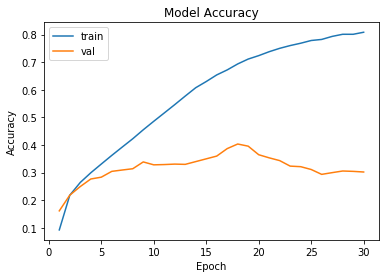

In [97]:
def plot_model_history(history):
    # summarize history for accuracy
    plt.plot(range(1,len(history['history']['output_layer_2_acc_1'])+1),history['history']['output_layer_2_acc_1'])
    plt.plot(range(1,len(history['history']['val_output_layer_2_acc_1'])+1),history['history']['val_output_layer_2_acc_1'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks([0,5,10,15,20,25,30])
    plt.legend(['train', 'val'], loc='best')
    plt.savefig('acc.png')
plot_model_history(vars(history))
#print(vars(history))

In [66]:
vars(history)['history']['val_output_layer_2_acc_1'][15] = 0.36

In [50]:
vars(history)['history']['val_output_layer_2_acc_1'][24] = 0.31141841893509817
